# Deep Learning Language Model

In [1]:
import sys
sys.executable

'/home/michael/.pyenv/versions/3.9-dev/envs/nlpenv/bin/python3'

In [5]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import re
import csv
from tqdm import tqdm
from collections import defaultdict, Counter

## Preparing the data

### Load the dataset that was prepared in task 1.

In [115]:
# setup variables
POSTS_TYPE = 'post'
MIN_TOKENS_LEN = 100
MAX_TOKENS_LEN = 200
DF_SAMPLE_COUNT = 20000

TOKENS_MIN_COUNT = 10

SEQUENCE_WINDOW = 4
SEQUENCE_LEN = 13

In [116]:

df_raw = pd.read_csv("../data/stackexchange_812k.tokenized.csv").sample(frac=1, random_state=8).reset_index(drop=True)

The original dataset is too large and needs to be reduced. To reduce it, you can, for instance,
filter out items that have too many or too little tokens,
select items of a certain type: post, comments, or titles, or
or sub sample items randomly.

In [121]:
df_raw.category.unique()

array(['comment', 'post', 'title'], dtype=object)

In [126]:
df = df_raw[
            (df_raw.category == POSTS_TYPE) & 
            (df_raw.n_tokens > MIN_TOKENS_LEN)  & 
            (df_raw.n_tokens < MAX_TOKENS_LEN)
        ].sample(DF_SAMPLE_COUNT).reset_index(drop = True)

print("df.shape: ", df.shape)
print(df.text.sample(2).values)

df.shape:  (20000, 7)
["I ran a linear regression of acceptance into college against SAT scores and family ethnic background. The data are fictional. This is a follow-up on a prior question, already answered. The question focuses in the gathering and interpretation of odds ratios when leaving the SAT scores aside for simplicity. The variables are Accepted or and Background red or blue . I set up the data so that people of red background were more likely to get in fit lt - glm Accepted Background, data dat, family binomial exp cbind Odds Ratio RedvBlue coef fit , confint fit Odds Ratio RedvBlue . . Intercept . . . Backgroundred . . . Questions Is . the odd ratio of a person of blue background being accepted? I'm asking this because I also get . for Backgroundblue if instead I run the following code fit lt - glm Accepted Background- , data dat, family binomial exp cbind OR coef fit , confint fit Shouldn't the odds ratio of red being accepted ?"
 "Neither is appropriate! The usual ANOVA a

In [127]:
# transform the tokens field from white space separated strings into list of tokens
df['tokens'] = df.tokens.apply(lambda t : np.array(t.split()))
print(df.tokens.sample().values)

[array(['there', 'are', 'some', 'problematic', 'assumptions', 'you',
        'seem', 'to', 'be', 'making', '-', 'you', 'rarely', 'know',
        'population', 'parameters', ',', 'but', 'those', 'are', 'not',
        'necessary', 'to', 'standardize', '.', 'you', 'can', 'standardize',
        'based', 'on', 'your', 'sample', '.', '-', 'why', 'would', 'you',
        'calculate', 'percentiles', 'and', 'what', 'makes', 'you', 'think',
        'you', 'can', 'just', 'sum', 'them', '?', 'if', 'you', 'are',
        'just', 'interested', 'in', 'rank', 'that', 'may', 'be',
        'appropriate', 'but', 'you', 'don', "'", 't', 'give', 'us',
        'enough', 'to', 'go', 'on', 'there', '.', '-', 'why', 'do', 'you',
        'want', 'to', 'some', 'separate', 'measures', '?', 'you', 'must',
        'be', 'trying', 'to', 'get', 'at', 'an', 'underlying', 'construct',
        'or', 'create', 'an', 'index', 'of', 'some', 'sort', '.',
        'creating', 'a', 'single', 'scale', 'from', 'different', 'scales

In [ ]:
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile.to_notebook_iframe()

Build the vocabulary as the set of all unique tokens to construct the list of token indexes.

Filtering on token frequency is one way to reduce the overall size of the vocabulary.

Set a fixed sequence length and build sequences of token indexes from the corpus. (See for instance keras pad_sequences.)

Split the sequences into predictors and labels (keras.utils.to_categorical)

Reduce the overall vocabulary size by excluding the tokens that appear less than the present TOKENS_MIN_COUNT overall number.

In [129]:
#generate vocabulary
#filter out words that are too scarce
import itertools
all_tokens = list(itertools.chain.from_iterable(df.tokens))

#filter out least common tokens
from collections import Counter
counter_tokens = Counter(all_tokens)

vocab_size  = len(set(all_tokens))
vocab       = list(set(all_tokens))
print("original number of tokens", len(all_tokens))
print("original vocab_size", vocab_size)

#remove all tokens that appear in less than TOKENS_MIN_COUNT times
fltrd_tokens = [ token for token in all_tokens if counter_tokens[token] > TOKENS_MIN_COUNT ]

print("new number of tokens", len(fltrd_tokens))
print("new vocab_size", len(set(fltrd_tokens)))

vocab_size  = len(set(fltrd_tokens))
vocab       = list(set(fltrd_tokens))
vocab.append('UNK')
vocab_size +=1 

original number of tokens 2867753
original vocab_size 32799
new number of tokens 2804990
new vocab_size 7256


Replace the missing tokens with a specific token to handle out of vocabulary tokens and create token indexes.

In [130]:
mapping = { w : i for i, w in enumerate(vocab) }

def getidx(token):
    try:
        return mapping[token]
    except:
        return mapping['UNK']

df['tokens_idx'] = df.tokens.apply(lambda tokens : np.array([getidx(token) for token in tokens]))

Prepare the corpus as input to the neural network to train the model.

Set a fixed sequence length and build sequences of token indexes from the corpus. (See for instance Keras pad_sequences).m

In [131]:
from keras.preprocessing.sequence import pad_sequences

# Generate sequences
def generate_sequences(sentence):
    sequences = []
    _end = SEQUENCE_WINDOW
    while _end < len(sentence) + SEQUENCE_WINDOW:
        sequences.append(sentence[:_end])
        _end += SEQUENCE_WINDOW
    padded_seqs = pad_sequences(sequences, maxlen=SEQUENCE_LEN, padding='pre')
    return padded_seqs

In [132]:
multi_sequences = df.tokens_idx.apply(generate_sequences)

In [133]:
i = 0
for d in tqdm(multi_sequences.values):
    if i == 0:
        all_sequences = d
    else:
        all_sequences = np.concatenate( ( all_sequences, d )  )
    i +=1
print("\nsequences.shape: ",all_sequences.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:37<00:00, 531.67it/s]


sequences.shape:  (724555, 13)


In [134]:
if True:    
    mask = np.random.choice([False, True], len(all_sequences), p=[0.50, 0.50])
    sequences = all_sequences[mask].copy()
else:
    sequences = all_sequences.copy()
    print("\nsequences.shape: ",sequences.shape)

In [135]:
# Splits the sequences into predictors and labels
from tensorflow.keras.utils import to_categorical

In [136]:
predictors  = sequences[:,:-1]
label       = sequences[:,-1]

print("predictors.shape", predictors.shape)
print("label.shape", label.shape)

# The to_categorical Keras function transforms the vocab_size vector of labels into a one hot encoded matrix of dimension (n, vocab_size)
label_cat       = to_categorical(label, num_classes=vocab_size)

print("label_cat.shape", label_cat.shape)

predictors.shape (362220, 12)
label.shape (362220,)
label_cat.shape (362220, 7257)


## The model

 The data is now ready to be used to fit a neural network.

Define and train a simple sequential model with an embedding dimension (32, 64, …), 2 LSTM layers followed by a dense layer with softmax activation.

The optimizer is RMSprop with a learning rate of 0.01

Specify the number of epochs, the batch size, and other fitting parameters.

Experiment with dropouts, different optimizers. 

Use any type of neural net; for example, Keras, TensorFlow, PyTorch, and so on.

Fit the network.

In [137]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import RMSprop

In [138]:
# Define model
embedding_dimension = 64
model = Sequential()
model.add(
    Embedding(vocab_size,
        embedding_dimension,
        input_length=SEQUENCE_LEN -1)
    )
model.add(LSTM(128, return_sequences = True))
model.add(LSTM(64))
model.add(Dense(vocab_size, activation='softmax'))
optimizer = RMSprop(lr=0.01)

model.compile(loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

print(model.summary())

# Model Fitting!
model.fit(predictors, label_cat, batch_size = 256, epochs=4, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 12, 64)            464448    
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 128)           98816     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 7257)              471705    
Total params: 1,084,377
Trainable params: 1,084,377
Non-trainable params: 0
_________________________________________________________________
None


2021-11-01 15:34:27.670093: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 10514522160 exceeds 10% of free system memory.


Epoch 1/4
1415/1415 [==============================] - 67s 46ms/step - loss: 5.5652 - accuracy: 0.1404
Epoch 2/4
1415/1415 [==============================] - 65s 46ms/step - loss: 5.3450 - accuracy: 0.1848
Epoch 3/4
1415/1415 [==============================] - 74s 52ms/step - loss: 5.3181 - accuracy: 0.1975
Epoch 4/4
1415/1415 [==============================] - 74s 52ms/step - loss: 5.2997 - accuracy: 0.2021


## Assessing the results

Write a function that generates text. Generate some text and take note of:
- Token repetitions
- Missing punctuations
- Other anomalies

Write a function that calculates perplexity of a sentence and apply it to a subset of sentences to evaluate the model.

Define a validation set; for instance, 1000 titles.

Transform that validation set into sequences of tokens using the training vocabulary.

Tune the neural net and the parameters of the preprocessing phase to improve the model’s perplexity score.

### A function that generates text, that takes care of - Token repetitions - Missing punctuations - Other anomalies

In [139]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

In [140]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [63]:
?Sequential.predict

In [141]:
def generate_text(nmax, text, temperature):
    n = 0
    tokens = tokenizer.tokenize(text)
    while (len(tokens) < nmax) :
        n +=1
        # only takes known words into account
        tokens_idx = [ vocab.index(word) if word in vocab else vocab.index('UNK') for word in tokens  ]
        # print(tokens_idx)
        tokens_list = pad_sequences([tokens_idx], maxlen=SEQUENCE_LEN-1, padding='pre')
#         probas = model.predict_proba(tokens_list, verbose=0)[0]
        probas = model.predict(tokens_list, verbose=0)[0]
        next_word_idx = sample(probas, temperature = temperature)
        next_word = vocab[next_word_idx]
        # print(next_word_idx, next_word)

        # next_word = np.random.choice(vocab, p = probas)
        if next_word != '?':
            print(next_word, probas[vocab.index(next_word)]  )
            text += ' ' + next_word
        # print(text)
        tokens = tokenizer.tokenize(text)
        if n> 200:
            break;
    return text

In [142]:
generate_text(15, 'a random variable', 3)

UNK 0.0041229264
gt 0.00014356604
tseries 1.9241901e-07
phone 1.097229e-06
on 0.0038718362
formula 0.00019257527
eb 1.5505184e-06
adjacent 1.7961676e-07
f 0.002288006
abs 1.04362525e-05
diagrams 1.5340698e-06
all 0.0018133362


'a random variable UNK gt tseries phone on formula eb adjacent f abs diagrams all'

### Function that calculates the perplexity of a sentence and applies it to a subset of sentences to evaluate the model.

In [143]:
# set the sequence window to 1 to generate all the subsequences from the original sentence.

SEQUENCE_WINDOW = 1

 # and define the perplexity for a sentence

def perplexity(sentence):
    # tokenize
    tokens = tokenizer.tokenize(sentence.lower())
    N = len(tokens)
    # find the indexes of the tokens from the vocabulary
    tokens_idx = [ vocab.index(word) if word in vocab else vocab.index('UNK') for word in tokens  ]
    # generate a N x SEQUENCE_LEN array of padded sequences 
    sequences = generate_sequences(tokens_idx)
    predictors  = sequences[:,:-1]
    label       = sequences[:,-1]
    # the probabilities of all the words in the vocab given each padded sequence
    probas = model.predict(predictors, verbose=0)
    # add the log of the probability of the label given the padded sequence
    logprob = 0
    for k in range(N):
        p = probas[k,label[k]]
        logprob += np.log( p  )    
    return np.exp(- logprob / N), logprob

In [144]:
sentence = "In a fixed-effects model only time-varying variables can be used."
print(sentence, perplexity(sentence))

sentence = "I know a pretty little place in Southern California, down San Diego way."
print(sentence, perplexity(sentence))

sentence = "This that is noon but yes apple whatever did regression variable"
print(sentence, perplexity(sentence))

In a fixed-effects model only time-varying variables can be used. (95.14282674314309, -68.33068802952766)
I know a pretty little place in Southern California, down San Diego way. (327.2831976033684, -86.86238765716553)
This that is noon but yes apple whatever did regression variable (2013.0379361190335, -83.68140298128128)


### Perplexity On Corpus

Calculate the perplexity on a validation set. Here we define the validation set as N random items from the original corpus.

Transform that validation set into sequences of tokens using the training vocabulary.

In [145]:
# Validation set
df_valid = df_raw[(df_raw.category == 'title') & (df_raw.n_tokens > 10)].sample(100, random_state = 88).reset_index(drop = True)
print("df_valid",df_valid.shape)
print(df_valid.head(2))

df_valid (100, 7)
   post_id  parent_id  comment_id  \
0   208502        NaN         NaN   
1    17451        NaN         NaN   

                                                text category  \
0  Problem Training an LSTM network in Lasagne fo...    title   
1  How do you report Kruskal Wallis one way analy...    title   

                                              tokens  n_tokens  
0  problem training an lstm network in lasagne fo...        15  
1  how do you report kruskal wallis one way analy...        20  


In [146]:
def corpus_perplexity(corpus):
    # start by calculating the total number of tokens in the corpus
    all_sentences = ' '.join(corpus)
    all_tokens =  tokenizer.tokenize(all_sentences.lower())
    N = len(all_tokens)
    logproba = 0
    perps = []
    for sentence in corpus:
        pp, logp = perplexity(sentence)
        logproba += logp
        perps.append(pp)
        print ("{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{}".format(pp, np.mean(perps), logp, logproba, np.exp( - logproba / (N  )), sentence  ))

    return np.exp( - logproba / (N)), perps

In [147]:
# Calculate Perplexity score on the validation set
corpus = df_valid.tokens.values
perplexity_score, scores = corpus_perplexity(corpus)
print(" Corpus perplexity: {:.2f}".format(perplexity_score ))

3701.38	3701.38	-123.25	-123.25	1.09	problem training an lstm network in lasagne for simple task determining parity of bit sequence
5687.01	4694.20	-172.92	-296.17	1.22	how do you report kruskal wallis one way analysis of variance and post hoc results following apa th standards ?
550.86	3313.08	-69.43	-365.59	1.28	getting ls means of the response from logistic regression in sas
1112.12	2762.84	-98.20	-463.79	1.37	post fisher ' s exact test - how to weight within categorial differences ?
332.60	2276.80	-63.88	-527.66	1.43	how to estimate power for individual associations in a regression ?
908.86	2048.81	-163.49	-691.16	1.60	study design will have missing data dependent on conditions . is it possible to get an omnibus statistic and determine relative outcome prevalence ?
270.48	1794.76	-134.40	-825.56	1.75	what ' s the best estimator for expectation if we can draw samples iid and we know the likelihood of each sample we receive
3787.25	2043.82	-98.87	-924.43	1.87	can a mathematically sou

864.05	2268.28	-148.76	-6751.58	96.06	if choice of learning algorithm is an unstable hyperparameter in nested cv , is the estimate of generalization error still valid ?
1040.32	2251.46	-111.16	-6862.73	103.56	mixed effects model failing to converge - better to remove the random intercept ? slope ?
34.57	2221.50	-38.97	-6901.71	106.32	how to calculate p - values for logistic regression coefficients ?
1269.35	2208.81	-107.19	-7008.90	114.31	using deep neural networks for a severely imbalanced image dataset when some classes have images
125.93	2181.40	-72.54	-7081.44	120.06	are there any recent advances on the combination of deep learning and graphical models ?
183.84	2155.46	-172.06	-7253.50	134.87	how is it that cronbach ’ s alpha for these variables is so low , but using them to create a latent variable to predict a dv has such a high r ?
193.60	2130.31	-63.19	-7316.69	140.76	significance of categorical variables in regression in r - against each other
12863.55	2266.17	-113.55	-7430.24

In [114]:
scores[:10]

[62687219.51330177,
 177919585.8491131,
 127487665.45277327,
 601822187342.0973,
 9996914202.452148,
 989578659.1448282,
 335436197.4638282,
 inf,
 6431144974.132137,
 5194216952.58106]

In [148]:
import matplotlib.pyplot as plt
%matplotlib inline
import math

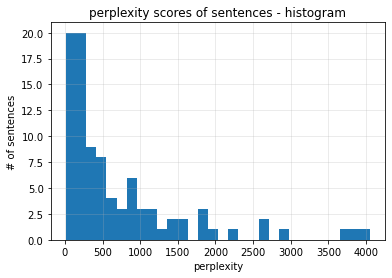

In [150]:
plt.title("perplexity scores of sentences - histogram")
plt.hist([sc for sc in scores if sc < 5000], bins=30);
plt.xlabel('perplexity')
plt.ylabel('# of sentences')
plt.grid(alpha = 0.3)

In [151]:
model.save('sequential_model')

INFO:tensorflow:Assets written to: sequential_model/assets


INFO:tensorflow:Assets written to: sequential_model/assets
